In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt

In [2]:
seed = 161
# random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
# Hyper Parameters
BATCH_SIZE          = 32
LR                  = 1e-3  # learning rate
EPSILON             = 0.9   # greedy policy
GAMMA               = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY     = 2000
SEGREGATION_BIAS    = 6     # no. of non-terminal memories in batch

In [4]:
env = gym.make('CartPole-v0')
# env = env.unwrapped
env.seed(seed);

In [5]:
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
        self.out = nn.Linear(50, N_ACTIONS)
        nn.init.xavier_uniform_(self.out.weight)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

In [7]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func           = nn.MSELoss()
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy()
        return actions_value
    
    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        if r > 0: #non-terminal rewards
            # replace the old memory with new memory
            index = self.good_memory_counter % int(MEMORY_CAPACITY/2)
            self.good_memory[index, :] = transition
            self.good_memory_counter += 1
        
        else: #terminal rewards
            # replace the old memory with new memory
            index = self.bad_memory_counter % int(MEMORY_CAPACITY/2)
            self.bad_memory[index, :] = transition
            self.bad_memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index = np.random.choice(int(MEMORY_CAPACITY/2), int(SEGREGATION_BIAS))
        bad_sample_index  = np.random.choice(int(MEMORY_CAPACITY/2), int(BATCH_SIZE-SEGREGATION_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [8]:
S_FILENAME = 'cartpole_limited.pt'
dqn = DQN()
dqn.eval_net.load_state_dict(torch.load(S_FILENAME))
dqn.eval_net.eval();

In [9]:
for QUANTIZATION_LEVEL in np.arange(3,41):
    print("QUANTIZATION LEVEL: ", QUANTIZATION_LEVEL)
    Q_TABLE = np.zeros((QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL, 
                    N_ACTIONS))
    
    c_pos_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
    c_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
    p_ang_s = np.linspace(-1, 1, QUANTIZATION_LEVEL)
    p_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
    
    
    for c_pos_indx in np.arange(0,c_pos_s.size):
        for c_vel_indx in np.arange(0,c_vel_s.size):
            for p_ang_indx in np.arange(0,p_ang_s.size):
                for p_vel_indx in np.arange(0,p_vel_s.size):

                        state = [c_pos_s[c_pos_indx],
                                 c_vel_s[c_vel_indx],
                                 p_ang_s[p_ang_indx],
                                 p_vel_s[p_vel_indx]]

                        Q_TABLE[c_pos_indx,
                                c_vel_indx,
                                p_ang_indx,
                                p_vel_indx, :] = dqn.get_qvals(state)
    
    FILENAME = S_FILENAME[:-3]+'_Q_TABLE_'+str(QUANTIZATION_LEVEL)
    np.save(FILENAME, Q_TABLE)
    

QUANTIZATION LEVEL:  3
QUANTIZATION LEVEL:  4
QUANTIZATION LEVEL:  5
QUANTIZATION LEVEL:  6
QUANTIZATION LEVEL:  7
QUANTIZATION LEVEL:  8
QUANTIZATION LEVEL:  9
QUANTIZATION LEVEL:  10
QUANTIZATION LEVEL:  11
QUANTIZATION LEVEL:  12
QUANTIZATION LEVEL:  13
QUANTIZATION LEVEL:  14
QUANTIZATION LEVEL:  15
QUANTIZATION LEVEL:  16
QUANTIZATION LEVEL:  17
QUANTIZATION LEVEL:  18
QUANTIZATION LEVEL:  19
QUANTIZATION LEVEL:  20
QUANTIZATION LEVEL:  21
QUANTIZATION LEVEL:  22
QUANTIZATION LEVEL:  23
QUANTIZATION LEVEL:  24
QUANTIZATION LEVEL:  25
QUANTIZATION LEVEL:  26
QUANTIZATION LEVEL:  27
QUANTIZATION LEVEL:  28
QUANTIZATION LEVEL:  29
QUANTIZATION LEVEL:  30
QUANTIZATION LEVEL:  31
QUANTIZATION LEVEL:  32
QUANTIZATION LEVEL:  33
QUANTIZATION LEVEL:  34
QUANTIZATION LEVEL:  35
QUANTIZATION LEVEL:  36
QUANTIZATION LEVEL:  37
QUANTIZATION LEVEL:  38
QUANTIZATION LEVEL:  39
QUANTIZATION LEVEL:  40


In [10]:
def discretize(c_pos_val, c_vel_val, p_ang_val, p_vel_val, c_pos_s, c_vel_s, p_ang_s, p_vel_s):
    c_pos_indx = np.where(c_pos_s >= c_pos_val)[0][0].astype(int)
    c_vel_indx = np.where(c_vel_s >= c_vel_val)[0][0].astype(int)
    p_ang_indx = np.where(p_ang_s >= p_ang_val)[0][0].astype(int)
    p_vel_indx = np.where(p_vel_s >= p_vel_val)[0][0].astype(int)
    return c_pos_indx, c_vel_indx, p_ang_indx, p_vel_indx

In [11]:
NO_OF_EPISODES = 1000

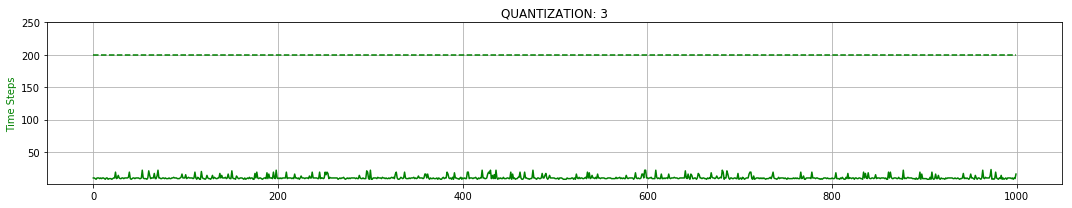

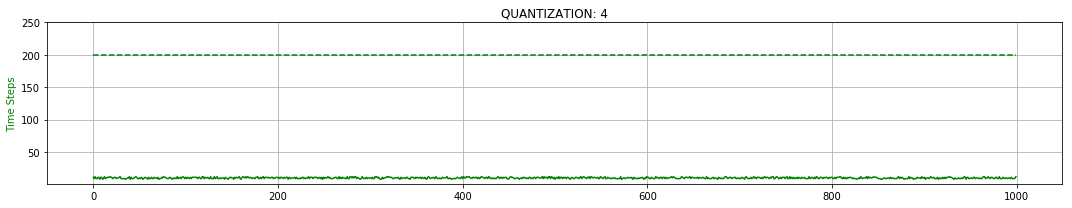

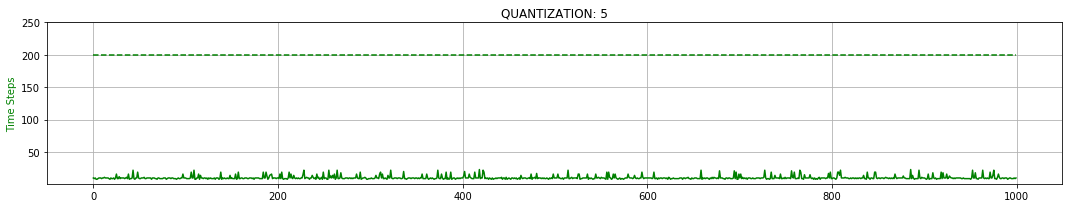

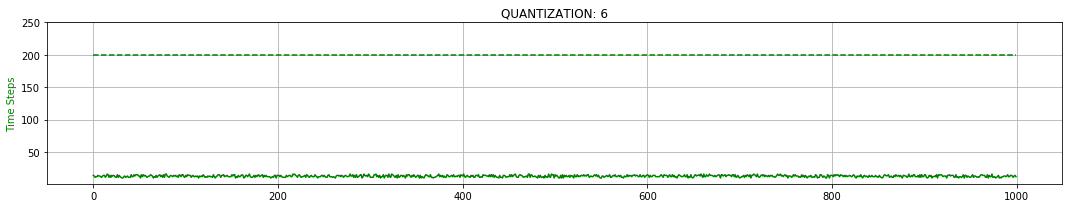

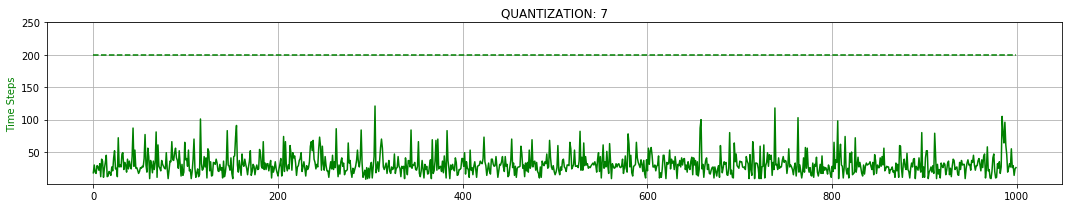

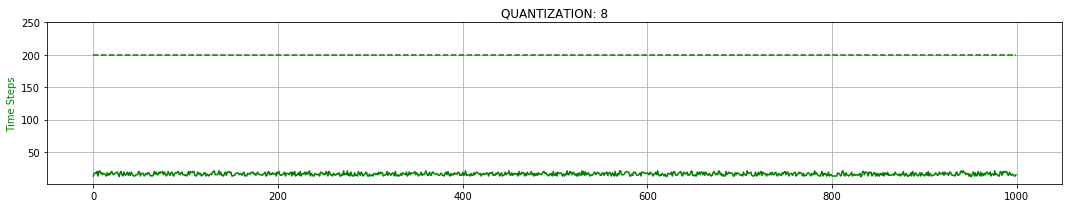

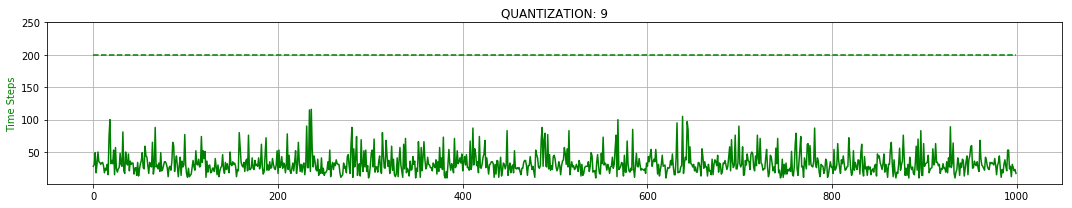

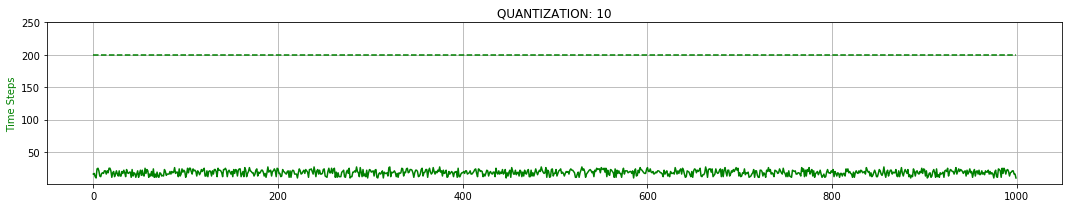

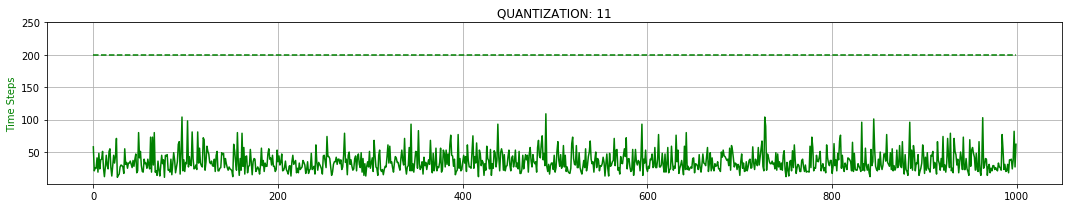

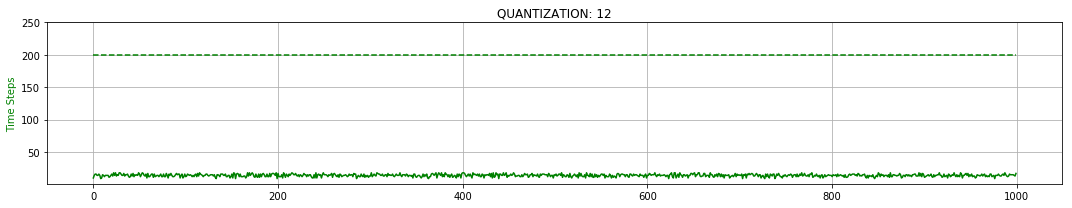

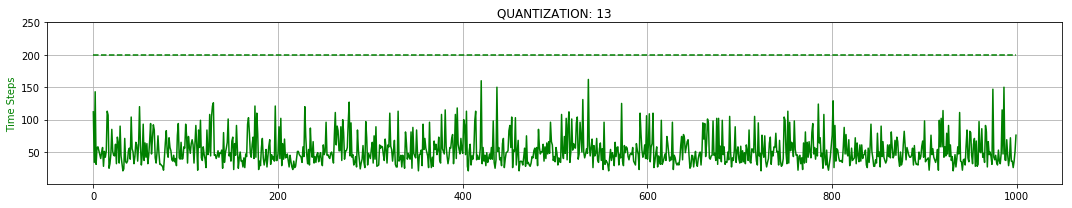

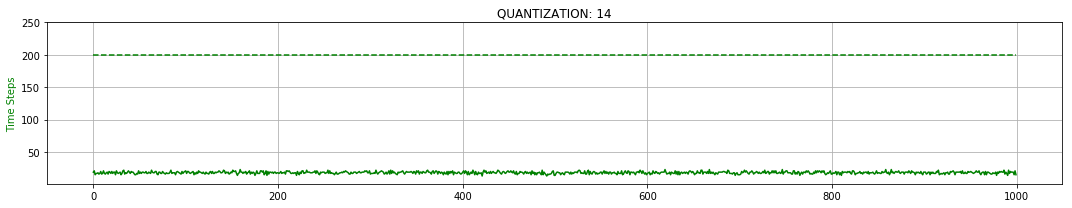

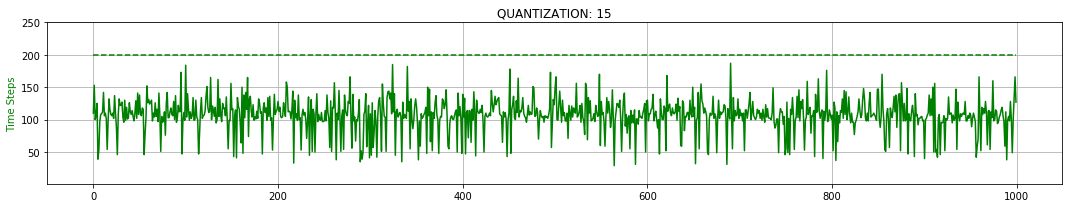

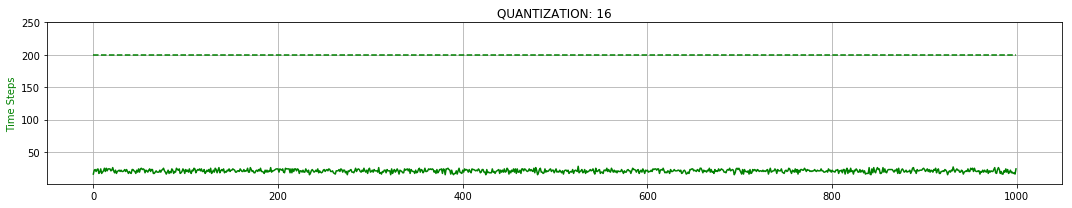

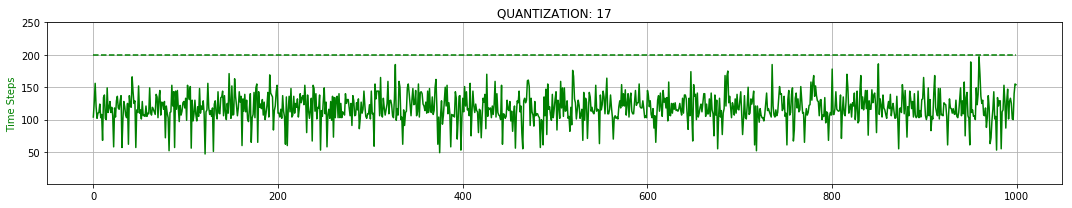

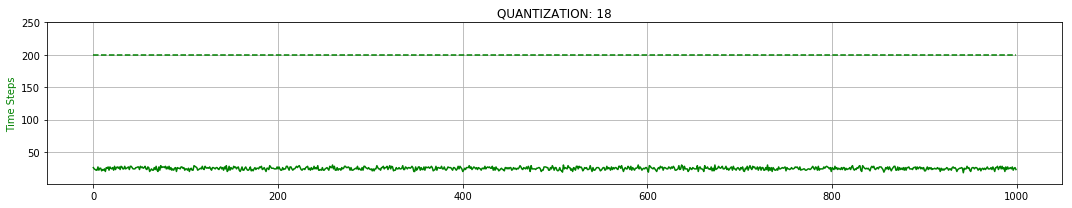

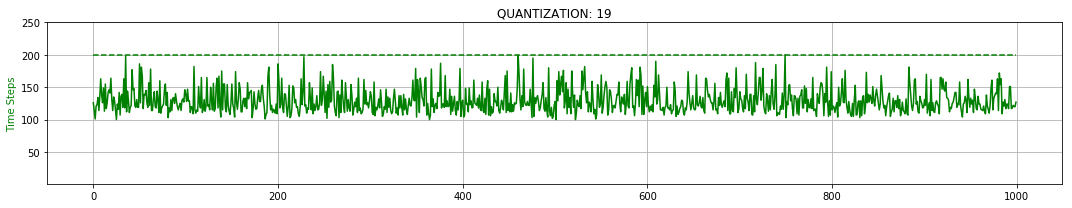

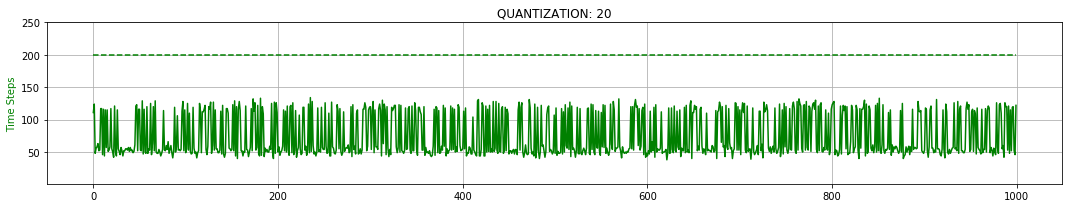

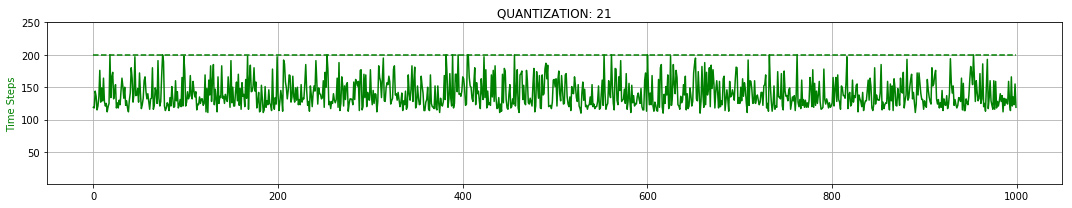

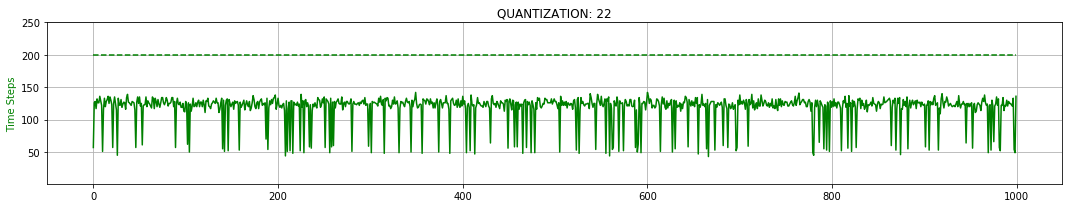

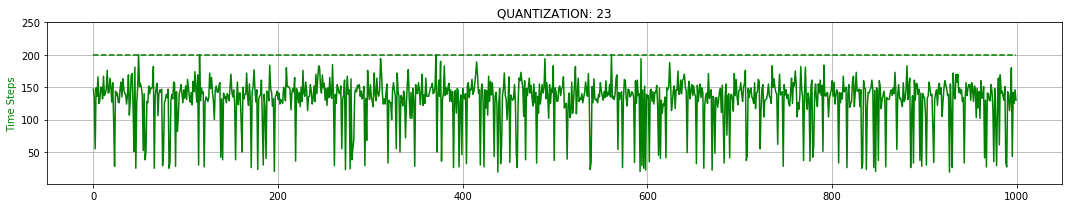

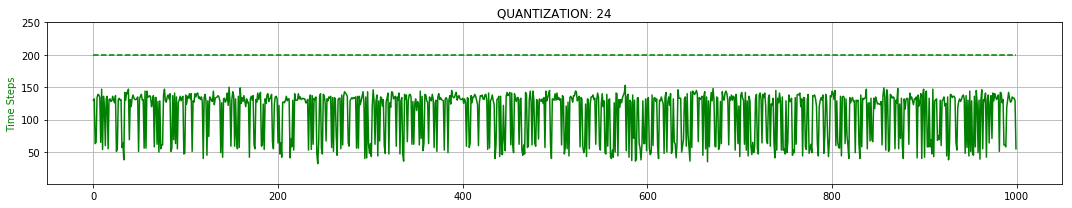

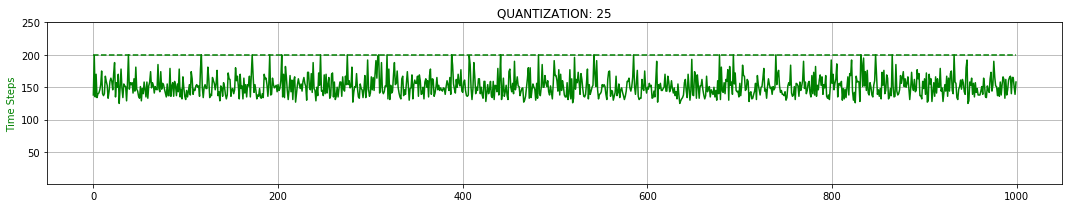

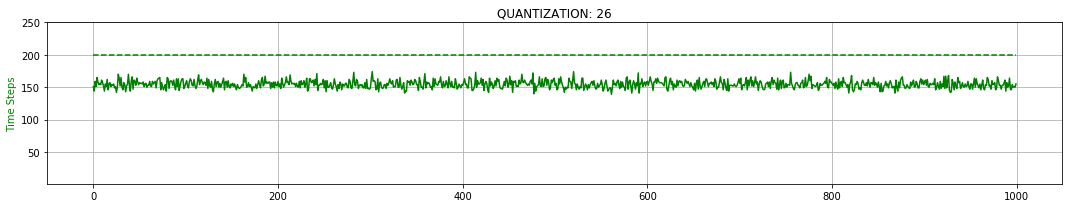

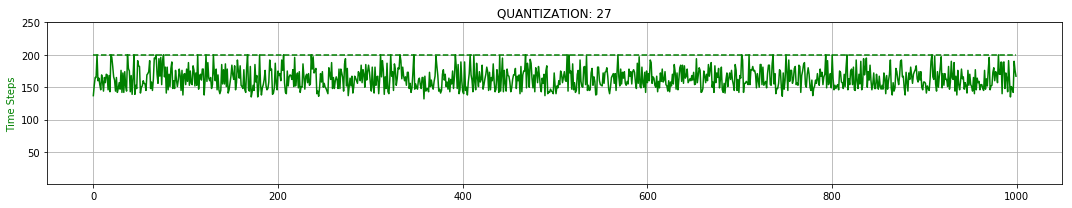

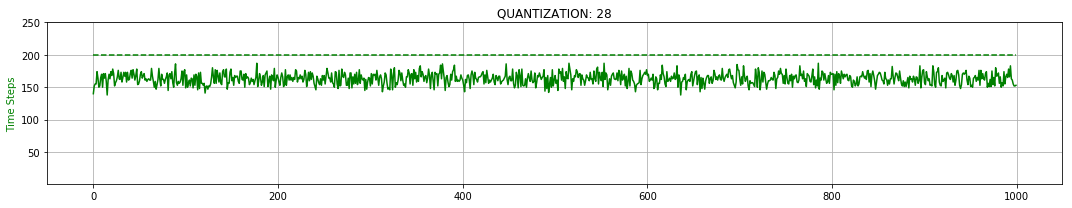

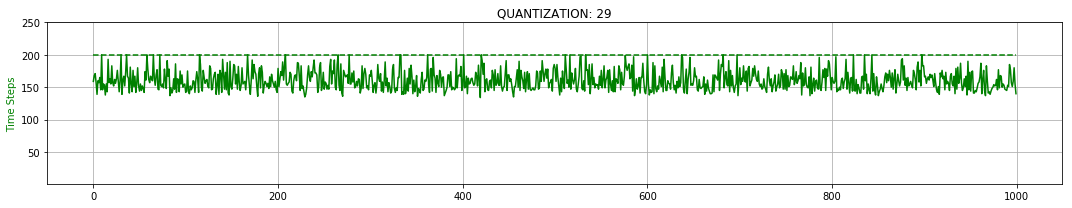

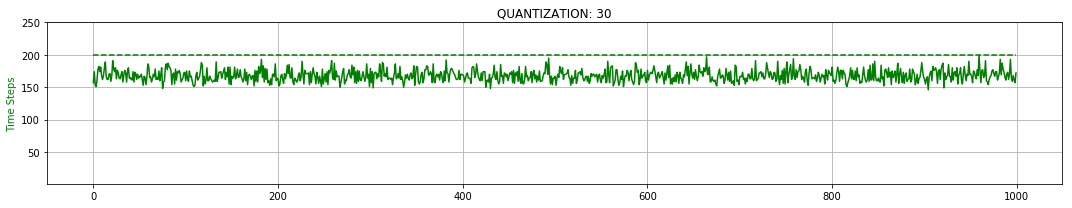

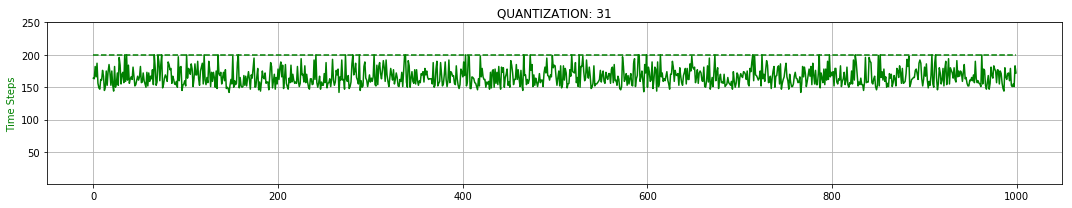

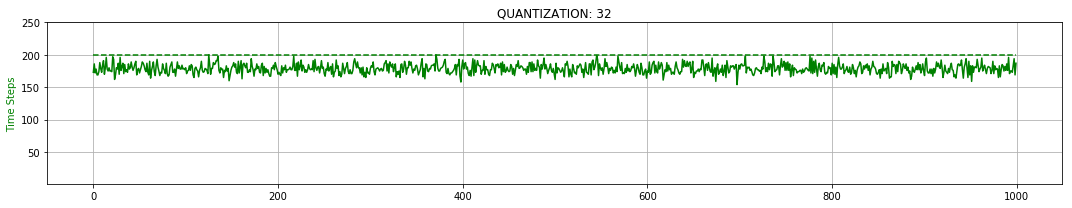

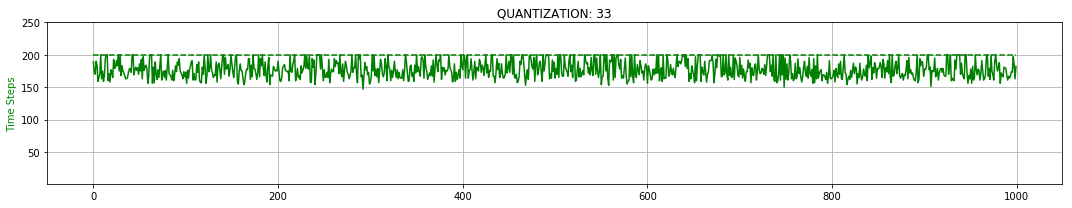

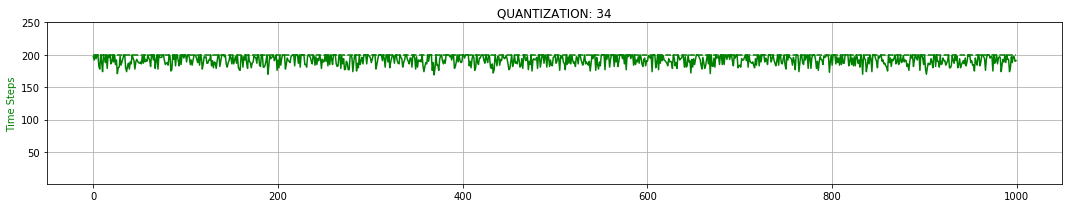

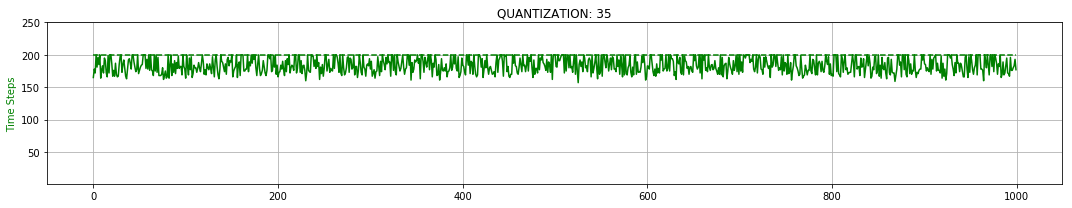

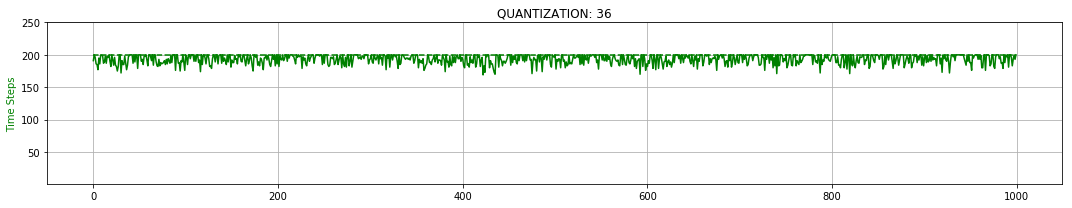

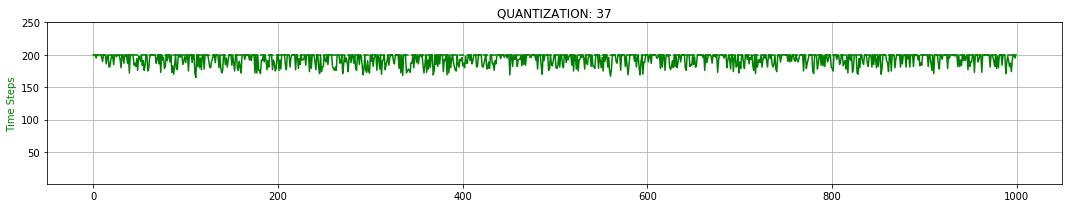

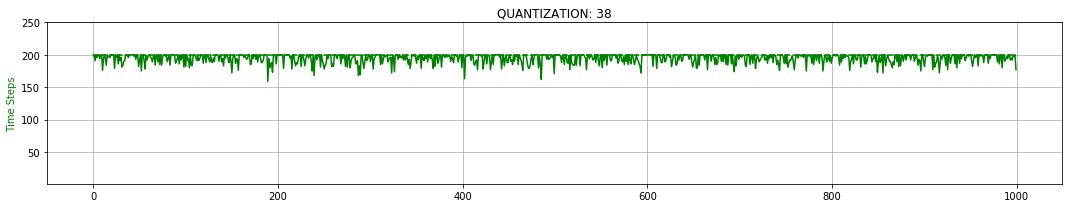

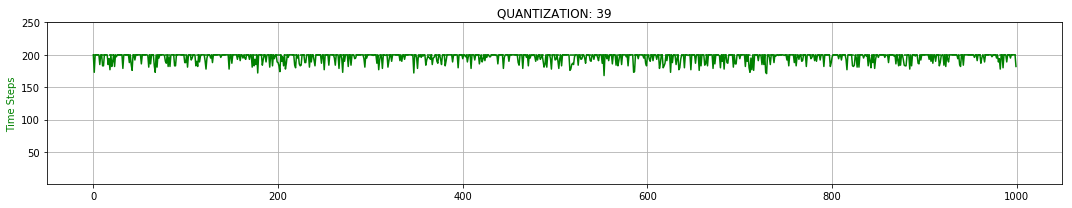

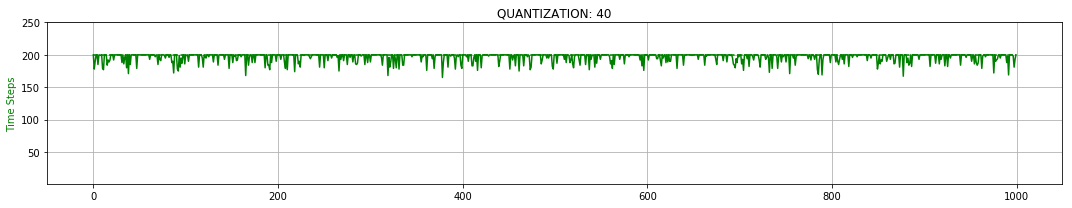

In [12]:
#TESTING
for QUANTIZATION_LEVEL in np.arange(3,41):
    time_rec = []
    M_FILENAME = S_FILENAME[:-3]+'_Q_TABLE_'+str(QUANTIZATION_LEVEL)+'.npy'
    Q_TABLE = np.load(M_FILENAME)
    
    c_pos_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
    c_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
    p_ang_s = np.linspace(-1, 1, QUANTIZATION_LEVEL)
    p_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
    
    for i_episode in range(NO_OF_EPISODES):

        time_steps = 0
        s = env.reset()
        while True:
    #         env.render()

            c_pos_state, c_vel_state, p_ang_state, p_vel_state = discretize(s[0],s[1],s[2],s[3],c_pos_s, c_vel_s, p_ang_s, p_vel_s)

            time_steps += 1
            a = Q_TABLE[c_pos_state, c_vel_state, p_ang_state, p_vel_state, :].argmax()

            # take action
            s_, r, done, info = env.step(a)

            if done:
                time_rec = np.append(time_rec, time_steps)

                break
            s = s_
    # env.close()

    fig = plt.figure(figsize = (15,3))
    
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.set_title("QUANTIZATION: "+str(QUANTIZATION_LEVEL))
    ax2.plot(data, color = 'g')
    ax2.plot(np.ones_like(data)*200, 'g--')

    ax2.set_ylabel('Time Steps',color = 'g')
    ax2.set_ylim([1,2.5e2])
    fig.tight_layout()
    ax2.grid()
    plt.show()